In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import shutil
# shutil.rmtree('/content/drive/MyDrive/baby_cry/data2')

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import librosa

from scipy.stats import skew
from scipy.stats import kurtosis, median_abs_deviation
from typing import Optional, Union

In [ ]:
# import zipfile

# def unzip_file(zip_filepath, dest_directory):
#     with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
#         zip_ref.extractall(dest_directory)
#     print(f"'{zip_filepath}' has been extracted to '{dest_directory}'")

# # 사용 예제
# zip_path = '/content/drive/MyDrive/baby_cry/data2.zip'
# unzip_dir = '/content/drive/MyDrive/baby_cry'
# unzip_file(zip_path,unzip_dir)

'/content/drive/MyDrive/baby_cry/data2.zip' has been extracted to '/content/drive/MyDrive/baby_cry'


In [3]:
main_path = '/content/drive/MyDrive/baby_cry'

# main_path = os.path.join(os.getcwd().rsplit(
#     'baby-cry-classification')[0], 'baby-cry-classification')
data_path = os.path.join(main_path, 'data2')
csv_path = os.path.join(main_path, 'origin_data_info.csv')
state_list = ['sad', 'hug', 'diaper', 'hungry', 'sleepy', 'awake', 'uncomfortable']

import sys
sys.path.append(main_path)

In [4]:
# from utils.os import *
# from utils.sound import *
# from trans_data.get_state_list import get_state_file_list

In [5]:
# Colab을 활용한다면 이 부분 주석 해제
def __format_extension(extension: Optional[Union[str, list[str]]]) -> Optional[list[str]]:
    if extension:
        if type(extension) == str:
            extension = [extension]
        extension = [ex.replace('.', '') for ex in extension]
    return extension


def __file_itorator(path: str,
                    include: Optional[list[str]] = None,
                    exclude: Optional[list[str]] = None):
    for (parent_path, dirs, files) in os.walk(path):
        for dir in dirs:
            __file_itorator(os.path.join(path, dir), include)

        for file in files:
            s = file.rsplit('.', 1)
            if len(s) == 1:
                continue
            if include and s[1] not in include:
                continue
            if exclude and s[1] in exclude:
                continue

            yield [parent_path, file]


# Itorate files with including and excluding files from path
def file_itorator(path: str,
                  include: Optional[Union[str, list[str]]] = None,
                  exclude: Optional[Union[str, list[str]]] = None):

    include = __format_extension(include)
    exclude = __format_extension(exclude)

    return __file_itorator(path, include, exclude)

def get_state_list_from_dir_name(data_path: str, with_path: bool = False, include_etc: bool = False) -> list[str]:
    """
    폴더 이름으로부터 state list를 추출한다.

    Parameters:
      data_path : state list를 추출할 폴더 경로

      with_path=False : True일 경우 state 폴더의 경로를 가져온다.

      include_etc=False : True일 경우 etc 폴더를 state에 포함한다.

    Returns:
      state 리스트를 반환한다.
    """
    state_list = []
    for dir in os.listdir(data_path):
        dir_path = os.path.join(data_path, dir)
        if os.path.isdir(dir_path):
            state_list.append(dir_path if with_path else dir)

    etc_path = os.path.join(data_path, 'etc')
    if include_etc == False and os.path.exists(etc_path):
        state_list.remove(etc_path if with_path else 'etc')
    return state_list


def get_state_file_list(data_path: str,
                        state_list: Optional[list[str]] = None,
                        include: Optional[Union[str, list[str]]] = None,
                        exclude: Optional[Union[str, list[str]]] = None):
    """
    각각의 state에서 n개의 무작위 파일을 선택하여 경로를 반환한다.

    Parameters:

        * data_path : 파일의 경로

        * state_list=None : state 리스트를 받을 경우 state_list가 포함하는 state 폴더의 파일들만 이름을 변경한다.

    Returns: 파일의 경로 리스트
    """
    if not os.path.exists(data_path):
        raise OSError(f'path {data_path} not exist.')

    # Get state list if not exist
    if state_list == None:
        state_list = get_state_list_from_dir_name(data_path)
    else:
        for state in state_list:
            if not os.path.exists(os.path.join(data_path, state)):
                raise OSError(
                    f"The path corresponding to state '{state}' does not exist.")

    file_list = []
    for state in state_list:
        file_list.extend([os.path.join(path, file) for path, file in file_itorator(
            os.path.join(data_path, state),
            include, exclude
        )])

    return file_list

# Get duration of sound file.
def get_duration(paths: str) -> float:
    return librosa.get_duration(path=paths)


In [6]:
def get_mfcc(file_path,
             sampling_freq=16000,
             mfcc_coef=40,
             mfcc_coef_retain=25,
             mfcc_window_duration=0.0232):
    """
    오디오 파일에 대한 MFCC를 분석한 뒤 값을 반환한다.

    Parameters:
        file_path:            오디오 파일의 경로
        sampling_freq:        sampling rate
        mfcc_coef:            frame의 길이를 결정하는 파라미터.
        mfcc_coef_retain:     유지되는 MFCC 값의 길이
        mfcc_window_duration: 데이터를 읽을 때 겹쳐 읽는 길이(sec)

    Returns:
        list[0]: 초반 mfcc_coef_retain 만큼의 MFCC 값
        list[1]: 평균, 분산, 표준편차와 같은 MFCC의 특성값
    """

    # load wav file and normalize
    wave, sr = librosa.load(file_path, mono=True, sr=sampling_freq)
    wave = librosa.util.normalize(wave)

    # feature extraction
    """
    ① sr: sampling rate
    ② n_mfcc=20 : mfcc의 개수
    ③ n_fft=25
        frame의 길이를 결정하는 파라미터 입니다. n_fft를 설정하면 window size가 자동으로 같은 값으로 설정되는데 window size의 크기로 잘린 음성이 n_fft보다 작은 경우 0으로 padding을 붙여주는 작업을 하기 때문에 n_fft는 window size보다 크거나 같아야 한다.
        보통 n_fft = sr * frame_length 로 설정
    ④ hop_length=10
        hop_length의 길이만큼 옆으로 가면서 데이터를 읽는다.
        10ms를 기본으로 하고 있어 16000Hz인 음성에서는 160에 해당한다. (16000 * 0.01 = 160)
        보통 hop_length는 = sr * frame_stride 로 설정한다.
    """
    mfccs = librosa.feature.mfcc(y=wave, sr=sr, n_mfcc=mfcc_coef, hop_length=int(
        mfcc_window_duration*sr/2.0), n_fft=int(mfcc_window_duration*sr))

    # 정규화: 평균이 0, 표준편차 1
    mfccs = (mfccs - np.mean(mfccs))/np.std(mfccs)

    # keep the first mfcc_coef_retain coefficients
    """
    일부 계수를 폐기하는 이유는 무엇입니까?
    일반적으로 하위 MFCC는 스펙트럼의 전체 모양에 대한 더 많은 정보를 포함하고(따라서 더 중요함) 상위 MFCC는 스펙트럼에서 더 미세한 세부 사항을 나타내기 시작합니다.
    처음 25개의 MFCC만 유지하도록 선택함으로써 작성자는 마지막 15개의 계수(26에서 40까지)가 모델의 증가된 복잡성을 정당화할 만큼 중요한 정보를 충분히 전달하지 않는다고 결정했을 가능성이 큽니다.
    즉, 유지할 MFCC 수의 선택은 문제에 따라 다를 수 있으며 다른 응용 프로그램이나 모델에는 다른 수가 필요할 수 있습니다. 일부 응용 프로그램의 경우 처음 13개의 계수만 사용되는 반면
    다른 응용 프로그램의 경우 40개 모두 사용될 수 있습니다. 주어진 작업에 대한 최적의 수를 찾으려면 종종 어느 정도의 실험이 필요합니다.
    """
    mfccs = mfccs[:mfcc_coef_retain, :]

    # calculate MFCC statistics
    mfccs_min = mfccs.min(axis=1)
    mfccs_max = mfccs.max(axis=1)
    mfccs_median = np.median(mfccs, axis=1)
    mfccs_mean = np.mean(mfccs, axis=1)
    mfccs_var = np.var(mfccs, axis=1)
    mfccs_skewness = skew(mfccs, axis=1)
    mfccs_kurtosis = kurtosis(mfccs, axis=1)
    mfccs_mad = median_abs_deviation(mfccs, axis=1)

    mfccs_first_derivative = np.diff(mfccs, n=1, axis=1)
    mfccs_first_derivative_mean = np.mean(mfccs_first_derivative, axis=1)
    mfccs_first_derivative_var = np.var(mfccs_first_derivative, axis=1)

    mfccs_second_derivative = np.diff(mfccs, n=2, axis=1)
    mfccs_second_derivative_mean = np.mean(mfccs_second_derivative, axis=1)
    mfccs_second_derivative_var = np.var(mfccs_second_derivative, axis=1)

    mfccs_stats = np.vstack((mfccs_min, mfccs_max, mfccs_median, mfccs_mean, mfccs_var, mfccs_skewness, mfccs_kurtosis, mfccs_mad,
                            mfccs_first_derivative_mean, mfccs_first_derivative_var, mfccs_second_derivative_mean, mfccs_second_derivative_var))

    return pd.Series([mfccs, mfccs_stats.transpose()])

In [ ]:
# file_list = get_state_file_list(data_path)

# df = pd.DataFrame({'file':file_list})
# df['duration'] = df['file'].apply(lambda file: get_duration(file))
# df['file'] = df['file'].apply(lambda file: file.rsplit('/', 1)[1])
# df['state'] = df['file'].apply(lambda file: file.split('_', 1)[0]).astype('category')
# df.tail(3)
# # df.to_csv(os.path.join(main_path, 'lstm.csv'))

In [9]:
df = pd.read_csv(os.path.join(main_path, 'lstm2.csv'), index_col=0)
df.tail(3)

,file,duration,state
10938,uncomfortable_135.wav,2.0,uncomfortable
10939,uncomfortable_121.wav,2.0,uncomfortable
10940,uncomfortable_647.wav,2.0,uncomfortable


In [10]:
sum = 0
for state in state_list:
  state_path = os.path.join(data_path, state)
  sum += len(os.listdir(state_path))
sum

10941

In [11]:
# Get MFCC data
from tqdm import tqdm

tqdm.pandas()
df[['mfccs', 'mfccs_stats']] = df.progress_apply(lambda x: get_mfcc(os.path.join(data_path, x['state'], x['file'])), axis=1)

# state 열을 카테고리 타입으로 변환한 다음 int 형태로 캐스팅한다.
df.state = df.state.astype('category')
df = df.assign(state_code=df.state.cat.codes)
df.info()

100%|██████████| 10941/10941 [42:16<00:00,  4.31it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10941 entries, 0 to 10940
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   file         10941 non-null  object  
 1   duration     10941 non-null  float64 
 2   state        10941 non-null  category
 3   mfccs        10941 non-null  object  
 4   mfccs_stats  10941 non-null  object  
 5   state_code   10941 non-null  int8    
dtypes: category(1), float64(1), int8(1), object(3)
memory usage: 449.1+ KB


In [12]:
def split_xy(df: pd.DataFrame):
    x = np.array(df['mfccs_stats'].to_list())
    x = x.reshape(x.shape[0], x.shape[1], x.shape[2])

    y = np.array(df['state_code'].to_list())
    y = y.reshape(y.shape[0], 1)

    return x, y

In [13]:
def get_lstm_model(num_classes):

    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(256, return_sequences=True),  # 첫 번째 LSTM 레이어
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.LSTM(128, return_sequences=False),  # 두 번째 LSTM 레이어
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])


    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=[
                  'sparse_categorical_accuracy'])

    return model

In [14]:
EPOCHS = 10000

In [15]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(df, test_size=0.2)
train, test = train_test_split(train, test_size=0.16)

X_train, Y_train = split_xy(train)
X_val, Y_val = split_xy(val)
X_test, Y_test = split_xy(test)

lstm_model = get_lstm_model(num_classes=10)

history = lstm_model.fit(X_train, Y_train, batch_size=128, epochs=EPOCHS, validation_data=(
    X_val, Y_val), callbacks=[], verbose=0)

accuracy_score = lstm_model.evaluate(X_test, Y_test)

44/44 [==============================] - 0s 5ms/step - loss: 2.2901 - sparse_categorical_accuracy: 0.7723


In [18]:
import matplotlib.pyplot as plt

In [20]:
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

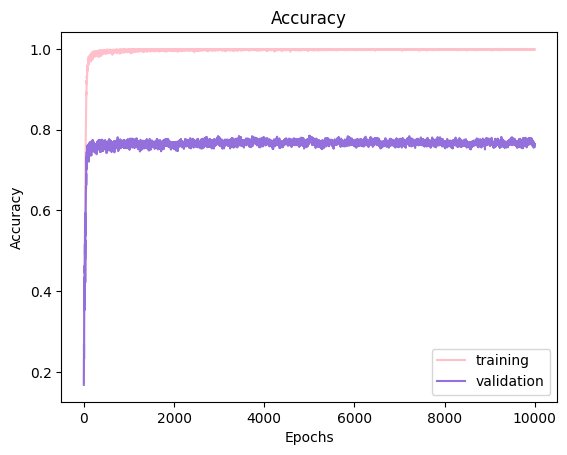

In [21]:
plt.plot(history.history['sparse_categorical_accuracy'], label='training', color='pink')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='validation', color='mediumpurple')  # 검증 데이터 정확도 추가
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [22]:
from sklearn.metrics import classification_report
lstm_test_preds = lstm_model.predict(X_test)
lstm_test_pred_classes = np.argmax(lstm_test_preds, axis=1)

print(classification_report(Y_test, lstm_test_pred_classes))

44/44 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.74      0.70      0.72       188
           1       0.75      0.75      0.75       217
           2       0.71      0.75      0.73       204
           3       0.74      0.79      0.77       195
           4       0.92      0.88      0.90       180
           5       0.84      0.76      0.79       209
           6       0.74      0.79      0.76       208

    accuracy                           0.77      1401
   macro avg       0.78      0.77      0.77      1401
weighted avg       0.77      0.77      0.77      1401

